<a href="https://colab.research.google.com/github/MarcCampmanyGar/fintech/blob/main/EDA_Fintech_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lectura de ficheros easyMoney

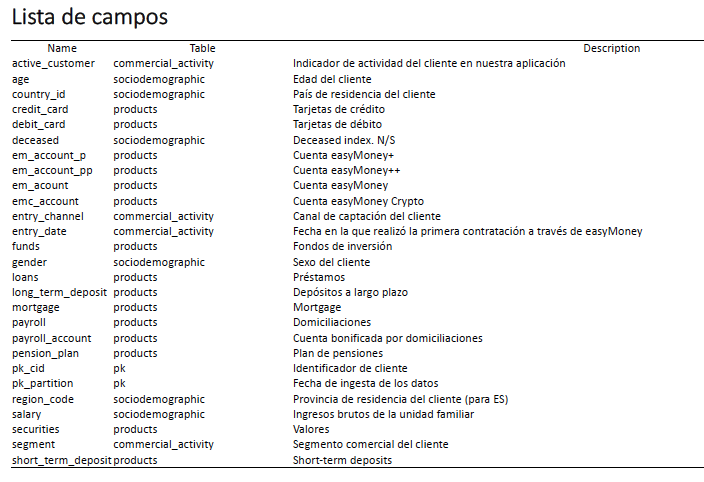

## Import Libraries

In [ ]:
import os
    
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

import time

from string import punctuation
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")

## Functions

In [ ]:
#10 € por cada cuenta vendida, 40€ por productos de ahorro e inversión (planes, fondos, etc) y 60 por finnanciación (prestamos y tarjetas)

v_10 = ['em_acount_diff', 'emc_account_diff', 'payroll_account_diff','em_account_p_diff']
v_40 = ['funds_diff', 'pension_plan_diff', 'short_term_deposit_diff', 'long_term_deposit_diff', 'securities_diff']
v_60 = ['loans_diff', 'mortgage_diff', 'debit_card_diff', 'credit_card_diff']

def calc_revenue(df):
  for column in df.columns:
    if 'diff' in column:
      if column in v_10:
        df['revenue_'+column] = 10*df[df[column]==1][column]
        df = df.drop(columns=column,axis=1)
      elif column in v_60:
        df['revenue_'+column] = 60*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
      else:
        df['revenue_'+column] = 40*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
  return df

In [ ]:
def alta_baja(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column[:-5]] = df[column[:-5]]
            new_df['baja_'+column] = df[df[column]==-1][column]
            new_df['alta_'+column] = df[df[column]==1][column]
            new_df['total_'+column] = df[column]
    return new_df

In [ ]:
def revenue_productos(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column] = df[column]
    return new_df

In [ ]:
class Plots(object):
    
    def __init__(self, df, products=[]):
        
        self.df = df
        self.products = products

    def alta_baja_plot(self): #Función para plotear altas y bajas por producto
        # resample the data on a monthly basis
        sns.set(style="darkgrid")
        
        #Dataframe para plotear el total de bajas y altas para el grupo entero de productos introducido
        x_sum_altas = self.df.groupby(["pk_partition"])[['alta_'+product+'_diff' for product in self.products]].sum()
        x_sum_bajas = self.df.groupby(["pk_partition"])[['baja_'+product+'_diff' for product in self.products]].sum()
        
        x_sum_altas = x_sum_altas.sum(axis=1)
        x_sum_bajas = x_sum_bajas.sum(axis=1)
        
        x_sum_altas.index = x_sum_altas.index.strftime('%B %Y')
        x_sum_bajas.index = x_sum_bajas.index.strftime('%B %Y')
        
        #Plot de altas y bajas para cada producto
        for product in self.products:
            x = self.df[["pk_partition",product,'baja_'+product+'_diff','alta_'+product+'_diff',
                              'total_'+product+'_diff']].set_index("pk_partition").resample("M").sum()
            fig, ax =plt.subplots(1,2,figsize = (18, 7))
            x.index = x.index.strftime('%B %Y')

            bar1 = sns.barplot(x=x.index,y=x['baja_'+ product +'_diff'],color='darkblue',ax=ax[0])
            bar2 = sns.barplot(x=x.index, y=x['alta_'+ product +'_diff'], estimator=sum, ci=None,  color='lightblue',ax=ax[0])
            line1 = sns.lineplot(data = x['total_'+ product+'_diff'], marker='o', sort = False, color = 'lightcoral',ax=ax[0])
            line2 = sns.lineplot(data = x[product],marker='o',sort = False, color = 'coral',ax=ax[1])
            
            top_bar = mpatches.Patch(color='darkblue', label='Withdraw')
            bottom_bar = mpatches.Patch(color='lightblue', label='Subscription')
            balance_line = mpatches.Patch(color = 'lightcoral',label = 'Balance')
            total_line = mpatches.Patch(color = 'coral',label = 'Total')

            ax[0].legend(handles=[top_bar, bottom_bar,balance_line])
            ax[0].tick_params(labelrotation=45)
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(product)
            ax[0].title.set_text("Monthly subscriptions")

            ax[1].legend(handles=[total_line])
            ax[1].tick_params(labelrotation=45)
            ax[1].set_xlabel('Time')
            ax[1].set_ylabel(product)
            ax[1].title.set_text("Total active subscriptors")

            plt.show()
            
        #Plot del total de bajas y altas del grupo entero de productos.    
        plt.figure(figsize = (18, 7)) 
        bar_sum_altas = sns.barplot(x=x_sum_altas.index,y=x_sum_altas.values,color='lightblue')
        bar_sum_bajas = sns.barplot(x=x_sum_bajas.index,y=x_sum_bajas.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for the entire group")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def alta_baja_total(self): #función para plotear altas y bajas totales de todos los productos de la empresa

        x_total_alta = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'alta' in column]].sum()
        x_total_baja = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'baja' in column]].sum() 

        x_total_alta = x_total_alta.sum(axis=1)
        x_total_baja = x_total_baja.sum(axis=1)
        
        x_total_alta.index = x_total_alta.index.strftime('%B %Y')
        x_total_baja.index = x_total_baja.index.strftime('%B %Y') 
        
        plt.figure(figsize = (18, 7)) 
        
        altas = sns.barplot(x=x_total_alta.index,y=x_total_alta.values,color='lightblue')
        bajas = sns.barplot(x=x_total_baja.index,y=x_total_baja.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for all portfolio")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def revenue_plot(self):

        for index in range(len(self.products)):
            self.products[index] = 'revenue_'+self.products[index]+'_diff'
        # resample the data on a monthly basis

        x = self.df[["pk_partition"]+self.products].set_index("pk_partition").resample("M").sum()
        x.index = x.index.strftime('%B %Y')

        x = x.reset_index()
        x_melted = x.melt(id_vars='pk_partition')

        plt.figure(figsize = (18, 7))
        sns.barplot(x='pk_partition', y='value', hue='variable', data=x_melted)
        plt.title("Monthly sales")
        plt.xticks(rotation=45)
        plt.legend();

        
    def total_revenue_plot(self):

        
        x_total_revenue = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'revenue' in column]].sum()

        x_total_revenue = x_total_revenue.sum(axis=1)
        
        x_total_revenue.index = x_total_revenue.index.strftime('%B %Y')

        plt.figure(figsize = (18, 7)) 
        sns.barplot(x=x_total_revenue.index,y=x_total_revenue.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'darkblue',label = 'Total revenue')

        
        plt.title("Monthly revenue for all portfolio")
        plt.legend(handles = [sum_bar])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()

## Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "/content/drive/MyDrive/Master Data Science/Capstone NDS/Dataset/"
os.chdir(PATH)

In [ ]:
comm = pd.read_csv(PATH + 'commercial_activity_df.csv', index_col=0)
products = pd.read_csv(PATH + 'products_df.csv', index_col=0)
sociodemo = pd.read_csv(PATH + 'sociodemographic_df.csv',  index_col=0)

## 2) Data Undersanding - Products 

[texto del enlace](https://)### Visualización, tamaño dataset, tipo atributos, estadísticos descrip.

In [ ]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1


In [ ]:
products.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 13647308
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 818.9+ MB


In [ ]:
#Vemos que tiene 17 columnas y casi 6M filas
#El id pk_cid es de tipo int y debería ser un object
# pk_partition se podrías pasar a datetime
#la columna em_acount tiene error ortográfico, debería ser em_account
#el resto todo son integers con valores (0,1), a confirmar

In [ ]:
products.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,"5,962,924.00","1,234,929.80","162,302.04","15,891.00","1,112,532.00","1,231,097.00","1,352,339.00","1,553,689.00"
short_term_deposit,"5,962,924.00",0.00,0.05,0.00,0.00,0.00,0.00,1.00
loans,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
mortgage,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
funds,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
securities,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
long_term_deposit,"5,962,924.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00
em_account_pp,"5,962,924.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
credit_card,"5,962,924.00",0.01,0.11,0.00,0.00,0.00,0.00,1.00
payroll,"5,962,863.00",0.03,0.18,0.00,0.00,0.00,0.00,1.00


In [ ]:
#se observa que la columna em_account_pp no tiene información, solo 0s
#todo el resto de variables excepto el id son binarias de 0,1. Lo vemos también con un for y value_counts()

In [ ]:
for i in products.columns:
  if i in ['pk_cid', 'pk_partition']:
    pass
  else:
      print(products[i].value_counts())

0    5947530
1      15394
Name: short_term_deposit, dtype: int64
0    5962456
1        468
Name: loans, dtype: int64
0    5962600
1        324
Name: mortgage, dtype: int64
0    5942825
1      20099
Name: funds, dtype: int64
0    5940791
1      22133
Name: securities, dtype: int64
0    5862264
1     100660
Name: long_term_deposit, dtype: int64
0    5962924
Name: em_account_pp, dtype: int64
0    5892058
1      70866
Name: credit_card, dtype: int64
0.00    5757076
1.00     205787
Name: payroll, dtype: int64
0.00    5745061
1.00     217802
Name: pension_plan, dtype: int64
0    5633504
1     329420
Name: payroll_account, dtype: int64
0    5635963
1     326961
Name: emc_account, dtype: int64
0    5399956
1     562968
Name: debit_card, dtype: int64
0    5962890
1         34
Name: em_account_p, dtype: int64
1    4381602
0    1581322
Name: em_acount, dtype: int64


In [ ]:
#payroll y pension plan se deberían pasar a integers también al tener solo valores 1,0

In [ ]:
products['pk_partition'].value_counts()
#podemos ver que los meses/particiones del dataset van de enero-2018 hasta mayo-2019

2019-05-28    442995
2019-04-28    439627
2019-03-28    436183
2019-02-28    431727
2019-01-28    426875
2018-12-28    422481
2018-11-28    416387
2018-10-28    402300
2018-09-28    375323
2018-08-28    352922
2018-07-28    339339
2018-06-28    252104
2018-05-28    249926
2018-04-28    247463
2018-03-28    245258
2018-02-28    242521
2018-01-28    239493
Name: pk_partition, dtype: int64

In [ ]:
products.describe(include= 'object').T

,count,unique,top,freq
pk_partition,5962924,17,2019-05-28,442995


In [ ]:
#la única variable object es la de pk_partition en el dataset original

### Valores nulos

In [ ]:
products.select_dtypes(include = ['number']).isnull().sum()

pk_cid                 0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [ ]:
products.select_dtypes(include = ['object']).isnull().sum()

pk_partition    0
dtype: int64

In [ ]:
#vemos que los únicos nulos dentro del dataset de products son 'payroll' y 'pension_plan'
#del total de 5,962,863.00 filas, 61 registros suponen un porcentaje ínfimo

### Distribución del target

In [ ]:
#Para poder observar la distribución de los productos a través de los meses (particiones) es necesario crear nuevas variables de comparación
#para ver si el producto se ha adquirido (pasa de 0 a 1), sigue igual (pasa de 1 a 1 o de 0 a 0) o se ha dado de baja (de 1 a 0)
#lo haremos con la función shift para comparar versus cada partición anterior

In [ ]:
products_sorted = products.sort_values(by=['pk_cid', 'pk_partition'])

In [ ]:
products_sorted.head(10)

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
4078994,15891,2018-07-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
5319232,15891,2018-08-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
7451107,16063,2018-11-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
8617948,16063,2018-12-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
9401149,16063,2019-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
10426151,16063,2019-02-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
11171013,16063,2019-03-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
12220930,16063,2019-04-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
13026461,16063,2019-05-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
8618171,16203,2018-12-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0


In [ ]:
#vemos que dependiendo del cliente, tiene más o menos filas de datos, dependiendo de cuándo se incluyó en la bbdd

In [ ]:
#products_sorted['debit_card_previous_month'] = products_sorted.groupby('pk_cid')['debit_card'].shift(1)
#products_sorted['credit_card_previous_month'] = products_sorted.groupby('pk_cid')['credit_card'].shift(1)
#products_sorted['funds_previous_month'] = products_sorted.groupby('pk_cid')['funds'].shift(1)

#al tener muchas variables, lo haremos con una función. Creamos columna con la info del mes previo y con esa calculamos la diferencia +
#borramos la columna de mes previo.

def calc_dif(df, columna):
  if ('dif_', columna) in df.columns:
    pass
  elif columna in ['pk_cid', 'pk_partition']:
    pass
  else:
    df[(columna + '_previous_month')] = df.groupby('pk_cid')[columna].shift(1)
    df['dif_' + columna] = df[columna] - df[columna + '_previous_month']
    del(df[(columna + '_previous_month')])

In [ ]:
#aplicamos la función a cada columna del dataset

for i in products_sorted.columns:
  calc_dif(products_sorted, i)

In [ ]:
products_sorted.head(10)

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,dif_short_term_deposit,dif_loans,dif_mortgage,dif_funds,dif_securities,dif_long_term_deposit,dif_em_account_pp,dif_credit_card,dif_payroll,dif_pension_plan,dif_payroll_account,dif_emc_account,dif_debit_card,dif_em_account_p,dif_em_acount
4078994,15891,2018-07-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5319232,15891,2018-08-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00
7451107,16063,2018-11-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8617948,16063,2018-12-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9401149,16063,2019-01-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10426151,16063,2019-02-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11171013,16063,2019-03-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12220930,16063,2019-04-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13026461,16063,2019-05-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8618171,16203,2018-12-28,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#check de que los cálculos son correctos
products_sorted[products_sorted.pk_cid == 17457][['long_term_deposit','debit_card', 'em_acount', 'dif_long_term_deposit','dif_debit_card','dif_em_acount']]

,long_term_deposit,debit_card,em_acount,dif_long_term_deposit,dif_debit_card,dif_em_acount
417555,1,0,1,NaN,NaN,NaN
835582,1,0,1,0.00,0.00,0.00
1673319,1,0,1,0.00,0.00,0.00
2091540,1,0,1,0.00,0.00,0.00
2934362,1,0,1,0.00,0.00,0.00
3566422,1,0,1,0.00,0.00,0.00
4079275,1,0,1,0.00,0.00,0.00
5318497,1,0,1,0.00,0.00,0.00
5704520,1,1,1,0.00,1.00,0.00
6909489,0,0,1,-1.00,-1.00,0.00


In [ ]:
#iteración en el df products y no produts_sorted, para coger los productos originales
#

for i in products.columns:
  if i in ['pk_cid', 'pk_partition']:
    pass
  else:
    print( products_sorted['dif_' + i].value_counts())

0.00     5498647
-1.00       5339
1.00        2565
Name: dif_short_term_deposit, dtype: int64
0.00     5506514
1.00          23
-1.00         14
Name: dif_loans, dtype: int64
0.00     5506539
1.00          10
-1.00          2
Name: dif_mortgage, dtype: int64
0.00     5505271
1.00         891
-1.00        389
Name: dif_funds, dtype: int64
0.00     5504840
1.00        1256
-1.00        455
Name: dif_securities, dtype: int64
0.00     5499166
1.00        3997
-1.00       3388
Name: dif_long_term_deposit, dtype: int64
0.00    5506551
Name: dif_em_account_pp, dtype: int64
0.00     5485850
1.00       11012
-1.00       9689
Name: dif_credit_card, dtype: int64
0.00     5445486
1.00       34180
-1.00      26791
Name: dif_payroll, dtype: int64
0.00     5440445
1.00       36859
-1.00      29153
Name: dif_pension_plan, dtype: int64
0.00     5475657
1.00       21519
-1.00       9375
Name: dif_payroll_account, dtype: int64
0.00     5487277
1.00       14273
-1.00       5001
Name: dif_emc_account, dtyp

In [ ]:
# Podemos observar que los produtos 'em_account_pp' y 'em_account_p' no sufren altas ni bajas!

In [ ]:
# products_sorted = products_sorted.replace(-1,0)

In [ ]:
# products_sorted.groupby('pk_partition').sum()

In [ ]:
#se ganan 10€ por cada cuenta vendida ['em_account_pp', 'payroll_account', 'emc_account', 'em_account_p', 'em_acount']
#40€ por los productos de ahorro e inversión (planes, fondos, etc.) ['short_term_deposit', 'funds', 'securities', 'long_term_deposit', 'payroll', 'pension_plan']
#60€ por los de financiación (préstamos y tarjetas) ['loans', 'mortgage', 'credit_card', 'debit_card']

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].pivot_table(index='pk_partition', values=['dif_debit_card'], aggfunc=[len])

,len
,dif_debit_card
pk_partition,
2018-02-28,3617
2018-03-28,3941
2018-04-28,3407
2018-05-28,3111
2018-06-28,3614
2018-07-28,3865
2018-08-28,3593
2018-09-28,5199


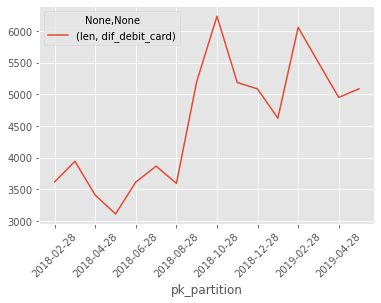

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].pivot_table(index='pk_partition', values='dif_debit_card', aggfunc=[len]).plot()
plt.xticks(rotation=45)
plt.show()

### EDA

#### Variación Productos

In [ ]:
products_sorted['pk_partition'] = (pd.to_datetime(products_sorted['pk_partition'])).dt.date

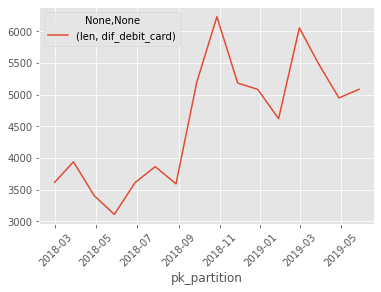

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].pivot_table(index='pk_partition', values='dif_debit_card', aggfunc=[len]).plot()
plt.xticks(rotation=45)
plt.show()

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].groupby('pk_partition')['dif_debit_card'].sum()

pk_partition
2018-02-28   3,617.00
2018-03-28   3,941.00
2018-04-28   3,407.00
2018-05-28   3,111.00
2018-06-28   3,614.00
2018-07-28   3,865.00
2018-08-28   3,593.00
2018-09-28   5,199.00
2018-10-28   6,230.00
2018-11-28   5,184.00
2018-12-28   5,083.00
2019-01-28   4,621.00
2019-02-28   6,055.00
2019-03-28   5,499.00
2019-04-28   4,949.00
2019-05-28   5,085.00
Name: dif_debit_card, dtype: float64

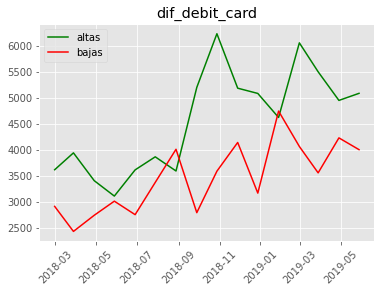

In [ ]:
altas = products_sorted[products_sorted['dif_debit_card'] == 1].groupby('pk_partition')['dif_debit_card'].sum()
bajas = products_sorted[products_sorted['dif_debit_card'] == -1].groupby('pk_partition')['dif_debit_card'].sum()*(-1)
fig = plt.figure()

plt.plot(altas, 'g-',label= 'altas')
plt.plot(bajas, 'r-', label = 'bajas')
plt.title('dif_debit_card')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
def altas_bajas(df, col):
  altas = df[df[col] == 1].groupby('pk_partition')[col].sum()
  bajas = df[df[col] == -1].groupby('pk_partition')[col].sum()*(-1)
  fig = plt.figure()

  plt.plot(altas, 'g-', label='altas')
  plt.plot(bajas, 'r-', label = 'bajas')
  plt.title(col)
  plt.legend()
  plt.xticks(rotation=45)
  plt.show()

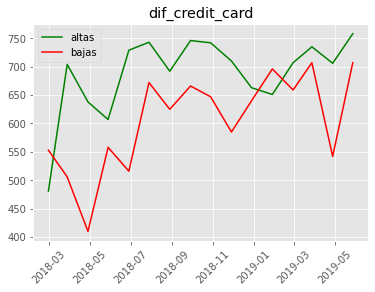

In [ ]:
altas_bajas(products_sorted, 'dif_credit_card')

In [ ]:
products_sorted.columns[17:]

Index(['dif_short_term_deposit', 'dif_loans', 'dif_mortgage', 'dif_funds',
       'dif_securities', 'dif_long_term_deposit', 'dif_em_account_pp',
       'dif_credit_card', 'dif_payroll', 'dif_pension_plan',
       'dif_payroll_account', 'dif_emc_account', 'dif_debit_card',
       'dif_em_account_p', 'dif_em_acount'],
      dtype='object')

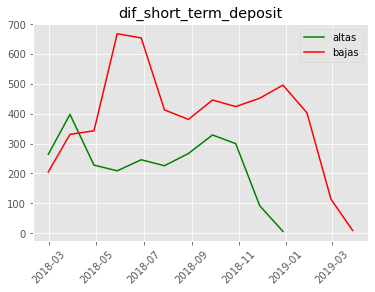

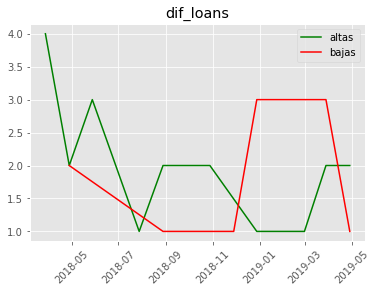

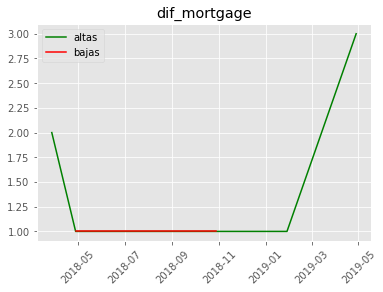

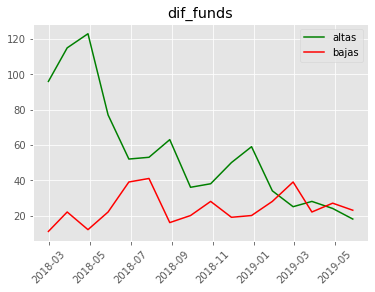

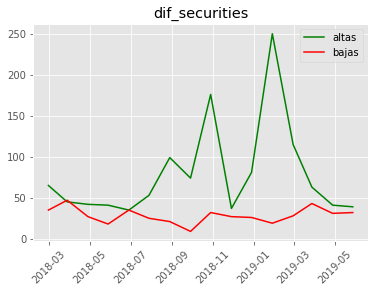

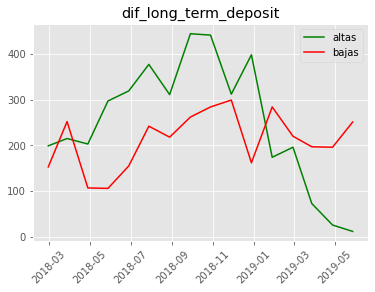

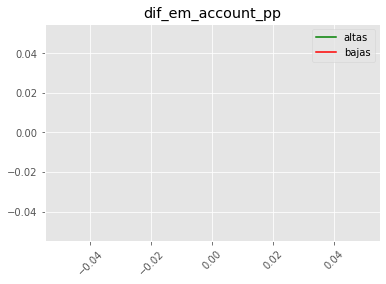

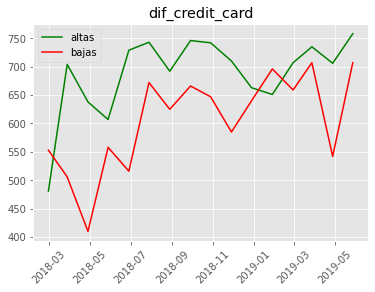

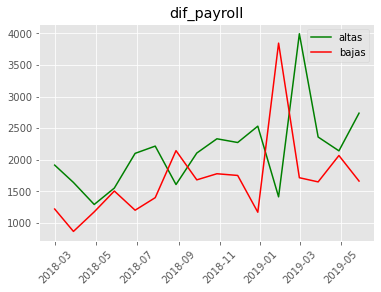

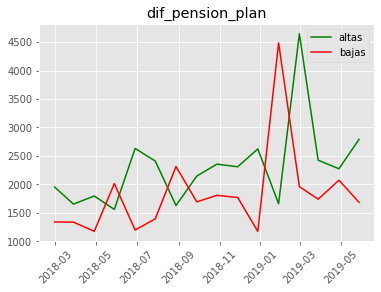

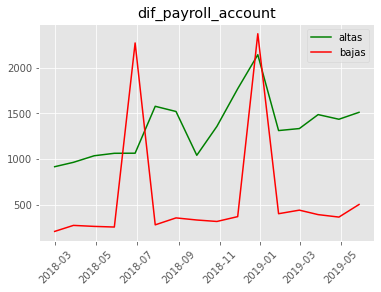

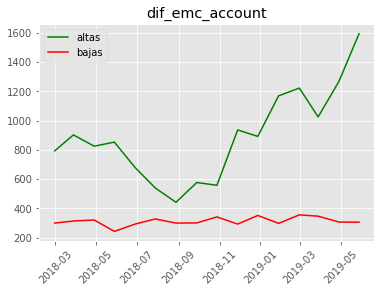

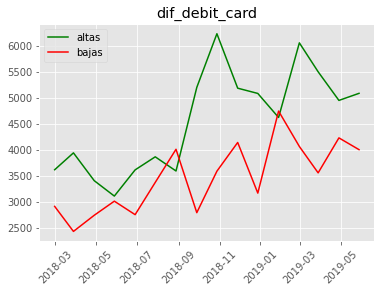

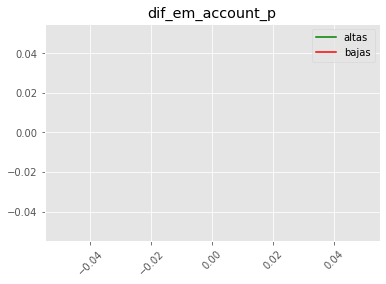

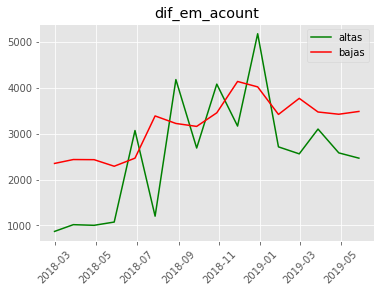

In [ ]:
for i in products_sorted.columns[17:]:
  altas_bajas(products_sorted, i)

#### Beneficios

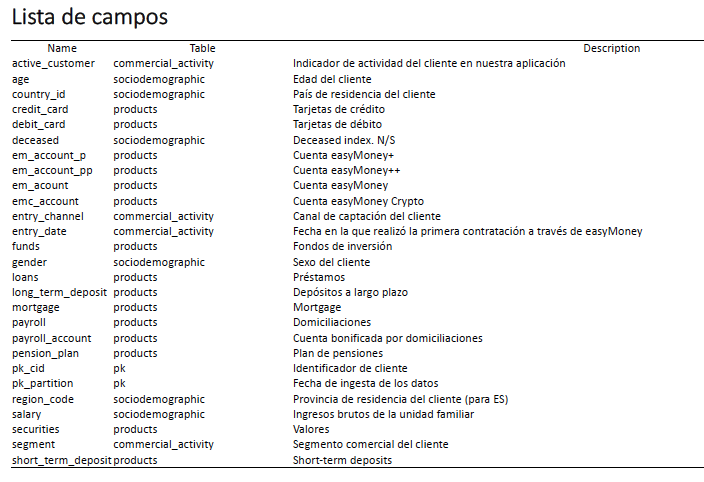

In [ ]:
#se ganan 10€ por cada cuenta vendida ['em_account_pp', 'payroll_account', 'emc_account', 'em_account_p', 'em_acount']
#40€ por los productos de ahorro e inversión (planes, fondos, etc.) ['short_term_deposit', 'funds', 'securities', 'long_term_deposit', 'payroll', 'pension_plan']
#60€ por los de financiación (préstamos y tarjetas) ['loans', 'mortgage', 'credit_card', 'debit_card']

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].groupby('pk_partition')['dif_debit_card'].sum()

pk_partition
2018-02-28   3,617.00
2018-03-28   3,941.00
2018-04-28   3,407.00
2018-05-28   3,111.00
2018-06-28   3,614.00
2018-07-28   3,865.00
2018-08-28   3,593.00
2018-09-28   5,199.00
2018-10-28   6,230.00
2018-11-28   5,184.00
2018-12-28   5,083.00
2019-01-28   4,621.00
2019-02-28   6,055.00
2019-03-28   5,499.00
2019-04-28   4,949.00
2019-05-28   5,085.00
Name: dif_debit_card, dtype: float64

In [ ]:
#crear diccionario vacío para los contadores de beneficio para cada periodo
d={}
for part in products_sorted['pk_partition'].unique():
  d[('beneficio_%s'%part).replace('-', '_')] = 0

In [ ]:
d

{'beneficio_2018_01_28': 0,
 'beneficio_2018_02_28': 0,
 'beneficio_2018_03_28': 0,
 'beneficio_2018_04_28': 0,
 'beneficio_2018_05_28': 0,
 'beneficio_2018_06_28': 0,
 'beneficio_2018_07_28': 0,
 'beneficio_2018_08_28': 0,
 'beneficio_2018_09_28': 0,
 'beneficio_2018_10_28': 0,
 'beneficio_2018_11_28': 0,
 'beneficio_2018_12_28': 0,
 'beneficio_2019_01_28': 0,
 'beneficio_2019_02_28': 0,
 'beneficio_2019_03_28': 0,
 'beneficio_2019_04_28': 0,
 'beneficio_2019_05_28': 0}

In [ ]:
for i in products_sorted.columns[29:30]:
  print(i)

dif_debit_card


In [ ]:
#iterar por cada producto, y por cada periodo donde tiene una alta para sumar su importe al beneficio total de ese periodo.

for i in products_sorted.columns[17:]:

  if i in ['dif_em_account_pp', 'dif_emc_account', 'dif_em_account_p', 'dif_em_acount']:
    for part_2 in products_sorted[products_sorted[i] == 1]['pk_partition'].unique():
      d[('beneficio_%s'%part_2).replace('-', '_')]  += products_sorted[products_sorted[i] == 1].groupby('pk_partition')[i].sum()[part_2]*10

  elif i in ['dif_short_term_deposit', 'dif_funds', 'dif_securities', 'dif_long_term_deposit', 'dif_payroll', 'dif_pension_plan', 'dif_payroll_account']:
    for part_3 in products_sorted[products_sorted[i] == 1]['pk_partition'].unique():
      d[('beneficio_%s'%part_3).replace('-', '_')]  += products_sorted[products_sorted[i] == 1].groupby('pk_partition')[i].sum()[part_3]*40

  elif i in ['dif_loans', 'dif_mortgage', 'dif_credit_card', 'dif_debit_card']:
    for part_4 in products_sorted[products_sorted[i] == 1]['pk_partition'].unique():
      d[('beneficio_%s'%part_4).replace('-', '_')]  += products_sorted[products_sorted[i] == 1].groupby('pk_partition')[i].sum()[part_4]*60

In [ ]:
d

{'beneficio_2018_01_28': 0,
 'beneficio_2018_02_28': 478670.0,
 'beneficio_2018_03_28': 499330.0,
 'beneficio_2018_04_28': 449760.0,
 'beneficio_2018_05_28': 434390.0,
 'beneficio_2018_06_28': 555910.0,
 'beneficio_2018_07_28': 570420.0,
 'beneficio_2018_08_28': 523140.0,
 'beneficio_2018_09_28': 636380.0,
 'beneficio_2018_10_28': 744690.0,
 'beneficio_2018_11_28': 668250.0,
 'beneficio_2018_12_28': 719070.0,
 'beneficio_2019_01_28': 548810.0,
 'beneficio_2019_02_28': 856040.0,
 'beneficio_2019_03_28': 672730.0,
 'beneficio_2019_04_28': 615640.0,
 'beneficio_2019_05_28': 675450.0}

In [ ]:
products_sorted[products_sorted['dif_debit_card'] == 1].pivot_table(index='pk_partition', values=['dif_debit_card'], aggfunc=[len])*60

,len
,dif_debit_card
pk_partition,
2018-02-28,217020
2018-03-28,236460
2018-04-28,204420
2018-05-28,186660
2018-06-28,216840
2018-07-28,231900
2018-08-28,215580
2018-09-28,311940


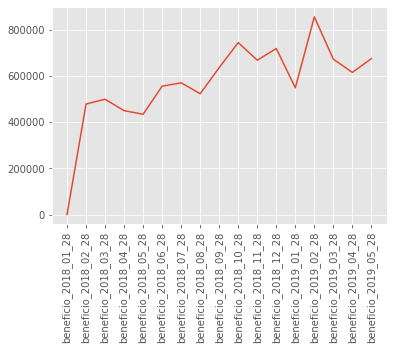

In [ ]:
keys = ['beneficio_2018_01_28','beneficio_2018_02_28','beneficio_2018_03_28','beneficio_2018_04_28','beneficio_2018_05_28','beneficio_2018_06_28','beneficio_2018_07_28','beneficio_2018_08_28','beneficio_2018_09_28','beneficio_2018_10_28','beneficio_2018_11_28','beneficio_2018_12_28','beneficio_2019_01_28','beneficio_2019_02_28','beneficio_2019_03_28','beneficio_2019_04_28','beneficio_2019_05_28']

values =  []
for key in keys:
  values.append(d[key])

plt.plot(keys, values)
plt.xticks(rotation=90)
plt.show()

## 2) Data Understanding - Sociodemographic

### Visualización, tamaño, tipos, estad.

In [ ]:
sociodemo.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01-28,ES,29.00,H,35,N,"87,218.10"
1,1050611,2018-01-28,ES,13.00,V,23,N,"35,548.74"
2,1050612,2018-01-28,ES,13.00,V,23,N,"122,179.11"
3,1050613,2018-01-28,ES,50.00,H,22,N,"119,775.54"
4,1050614,2018-01-28,ES,50.00,V,23,N,NaN


In [ ]:
sociodemo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 13647308
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 409.4+ MB


In [ ]:
# pk_cid es identificador, debería ser un object
# pk_partition es una fecha
# region code es un identificador también, no un float

In [ ]:
sociodemo.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,"5,962,924.00","1,234,929.80","162,302.04","15,891.00","1,112,532.00","1,231,097.00","1,352,339.00","1,553,689.00"
region_code,"5,960,660.00",25.81,13.60,1.00,13.00,28.00,36.00,52.00
age,"5,962,924.00",29.76,11.98,2.00,22.00,25.00,34.00,105.00
salary,"4,450,821.00","115,816.72","199,551.89","1,202.73","61,500.63","88,654.65","131,669.91","28,894,395.51"


In [ ]:
# vemos que para salario el max es 28M
# para edad el max es 105, podría ser

In [ ]:
sociodemo[sociodemo.salary >= 10000000].groupby('pk_cid')['salary'].mean()

pk_cid
409025    11,139,895.56
1069783   24,253,236.93
1072429   11,804,014.98
1079448   11,032,081.77
1089053   11,381,526.03
1104456   11,139,895.56
1204720   13,268,621.28
1209096   11,341,152.48
1227764   13,268,621.28
1227968   11,857,856.46
1247603   22,034,738.76
1250271   13,268,621.28
1258070   10,270,345.11
1264164   21,724,186.50
1305927   11,341,152.48
1329461   13,268,621.28
1350392   23,720,066.55
1362316   11,267,056.83
1362782   11,341,152.48
1368868   11,139,895.56
1371668   28,894,395.51
1396113   28,894,395.51
1427493   15,711,716.46
1451218   21,674,246.67
Name: salary, dtype: float64

In [ ]:
sociodemo[sociodemo['pk_cid']==1050613]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
3,1050613,2018-01-28,ES,50.00,H,22,N,"119,775.54"
1243388,1050613,2018-02-28,ES,50.00,H,22,N,"119,775.54"
1847831,1050613,2018-03-28,ES,50.00,H,22,N,"119,775.54"
4371721,1050613,2018-07-28,ES,50.00,H,22,N,"119,775.54"
5136573,1050613,2018-08-28,ES,50.00,H,22,N,"119,775.54"
6053845,1050613,2018-09-28,ES,50.00,H,23,N,"119,775.54"
6492088,1050613,2018-10-28,ES,50.00,H,23,N,"119,775.54"
8085367,1050613,2018-11-28,ES,50.00,H,23,N,"119,775.54"
8187877,1050613,2018-12-28,ES,50.00,H,23,N,"119,775.54"
9891559,1050613,2019-01-28,ES,50.00,H,23,N,"119,775.54"


In [ ]:
#para ver distribuciones cogeremos los valores de la última partición (2019-05-28	)

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].describe()

,pk_cid,region_code,age,salary
count,"442,995.00","442,833.00","442,995.00","295,284.00"
mean,"1,271,884.97",25.88,30.40,"116,674.77"
std,"177,957.39",13.54,12.24,"206,836.38"
min,"16,063.00",1.00,2.00,"1,202.73"
25%,"1,141,604.50",13.00,22.00,"61,627.71"
50%,"1,280,164.00",28.00,25.00,"88,979.34"
75%,"1,419,055.50",36.00,35.00,"132,485.89"
max,"1,553,689.00",52.00,105.00,"28,894,395.51"


In [ ]:
sociodemo.describe(include= 'object').T

,count,unique,top,freq
pk_partition,5962924,17,2019-05-28,442995
country_id,5962924,41,ES,5960672
gender,5962899,2,H,3087502
deceased,5962924,2,N,5961849


In [ ]:
sociodemo['country_id'].value_counts()

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64

### Valores Nulos

In [ ]:
sociodemo.select_dtypes(include = ['number']).isnull().sum()

pk_cid               0
region_code       2264
age                  0
salary         1512103
dtype: int64

In [ ]:
sociodemo['region_code'].value_counts(dropna=False)

28.00    1185757
8.00      600362
46.00     358142
30.00     296856
41.00     290447
15.00     254891
29.00     187911
36.00     175850
3.00      171358
11.00     160894
33.00     134562
50.00     132983
6.00      122587
35.00     121982
47.00     116948
18.00     102789
45.00     102328
37.00      92538
10.00      83283
14.00      75405
2.00       72071
21.00      72037
13.00      70092
39.00      69589
12.00      68709
7.00       62436
32.00      54639
27.00      52783
43.00      51782
17.00      50749
9.00       47746
25.00      46887
16.00      36094
24.00      35426
48.00      35256
26.00      34790
4.00       32680
31.00      31241
49.00      30965
23.00      30955
38.00      29001
34.00      27545
19.00      26762
40.00      21658
5.00       21300
22.00      21112
20.00      18833
1.00       12999
44.00      12616
42.00       8500
51.00       2896
52.00       2638
NaN         2264
Name: region_code, dtype: int64

In [ ]:
# muchísimos nulos en la columna de salario, dato dado por el cliente en el momento de la captación. Un 25% de los datos son nulos
(1512103 / 5962924)*100

25.358414764300196

In [ ]:
sociodemo.select_dtypes(include = ['object']).isnull().sum()

pk_partition     0
country_id       0
gender          25
deceased         0
dtype: int64

In [ ]:
sociodemo[sociodemo['gender'].isnull()]['pk_cid'].value_counts()
#corresponden a 2 ids

476023    15
216507    10
Name: pk_cid, dtype: int64

In [ ]:
sociodemo[sociodemo['pk_cid'] == 476023]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
1324482,476023,2018-03-28,ES,28.00,NaN,69,N,"89,991.42"
1959576,476023,2018-04-28,ES,28.00,NaN,69,N,"89,991.42"
3073415,476023,2018-05-28,ES,28.00,NaN,69,N,"89,991.42"
3705152,476023,2018-06-28,ES,28.00,NaN,69,N,"89,991.42"
3854354,476023,2018-07-28,ES,28.00,NaN,69,N,"89,991.42"
4829286,476023,2018-08-28,ES,28.00,NaN,69,N,"89,991.42"
5525093,476023,2018-09-28,ES,28.00,NaN,69,N,"89,991.42"
7134419,476023,2018-10-28,ES,28.00,NaN,69,N,"89,991.42"
7221537,476023,2018-11-28,ES,28.00,NaN,69,N,"89,991.42"
8798704,476023,2018-12-28,ES,28.00,NaN,69,N,"89,991.42"


In [ ]:
sociodemo[sociodemo['pk_cid'] == 216507]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
5417751,216507,2018-08-28,ES,28.00,NaN,72,N,"104,296.62"
5797798,216507,2018-09-28,ES,28.00,NaN,72,N,"104,296.62"
6949550,216507,2018-10-28,ES,28.00,NaN,72,N,"104,296.62"
7578659,216507,2018-11-28,ES,28.00,NaN,72,N,"104,296.62"
8525675,216507,2018-12-28,ES,28.00,NaN,72,N,"104,296.62"
9164692,216507,2019-01-28,ES,28.00,NaN,73,N,"104,296.62"
10500564,216507,2019-02-28,ES,28.00,NaN,72,N,"104,296.62"
11147897,216507,2019-03-28,ES,28.00,NaN,73,N,"104,296.62"
12090284,216507,2019-04-28,ES,28.00,NaN,73,N,"104,296.62"
13000310,216507,2019-05-28,ES,28.00,NaN,73,N,"104,296.62"


### EDA

#### Edades

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].describe()

,pk_cid,region_code,age,salary
count,"442,995.00","442,833.00","442,995.00","295,284.00"
mean,"1,271,884.97",25.88,30.40,"116,674.77"
std,"177,957.39",13.54,12.24,"206,836.38"
min,"16,063.00",1.00,2.00,"1,202.73"
25%,"1,141,604.50",13.00,22.00,"61,627.71"
50%,"1,280,164.00",28.00,25.00,"88,979.34"
75%,"1,419,055.50",36.00,35.00,"132,485.89"
max,"1,553,689.00",52.00,105.00,"28,894,395.51"


In [ ]:
#vemos que la media de edad es 30 años y el salario medio 206k, que parece demasiado alto. Los outliers de 28M lo deben desvirtuar

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28']['age'].value_counts().sort_values()

105        1
104        1
103        2
101        7
100        8
       ...  
20     24802
24     37028
21     46014
22     47429
23     49260
Name: age, Length: 104, dtype: int64

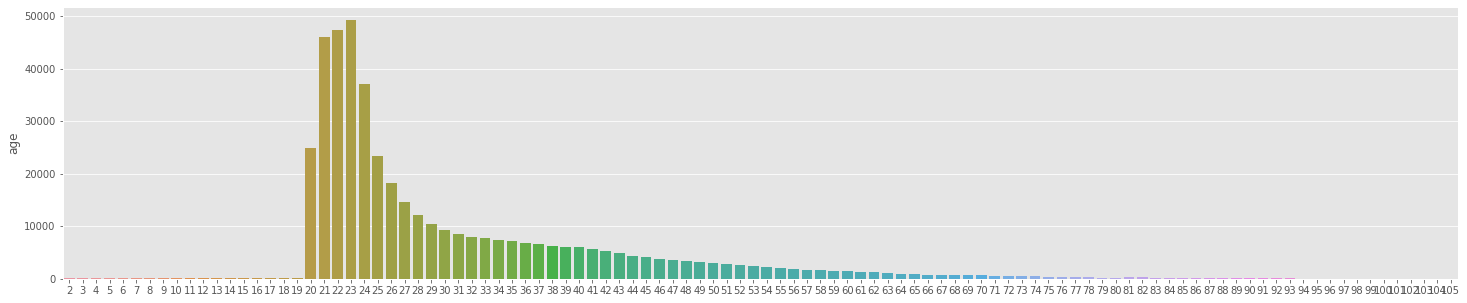

In [ ]:
dims = (25, 5)
fig= plt.subplots(figsize=dims)

sns.barplot(x=sociodemo[sociodemo['pk_partition'] == '2019-05-28'].age.value_counts().index, y=sociodemo[sociodemo['pk_partition'] == '2019-05-28'].age.value_counts())

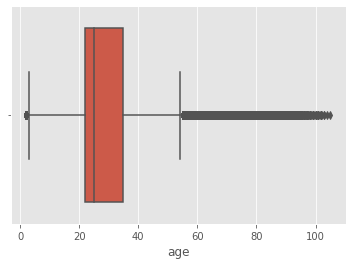

In [ ]:
sns.boxplot(x = sociodemo[sociodemo['pk_partition'] == '2019-05-28']['age'])

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].age.value_counts()

23     49260
22     47429
21     46014
24     37028
20     24802
       ...  
100        8
101        7
103        2
104        1
105        1
Name: age, Length: 104, dtype: int64

#### Género

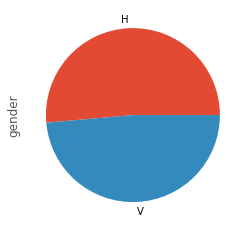

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].gender.value_counts().plot(kind='pie')

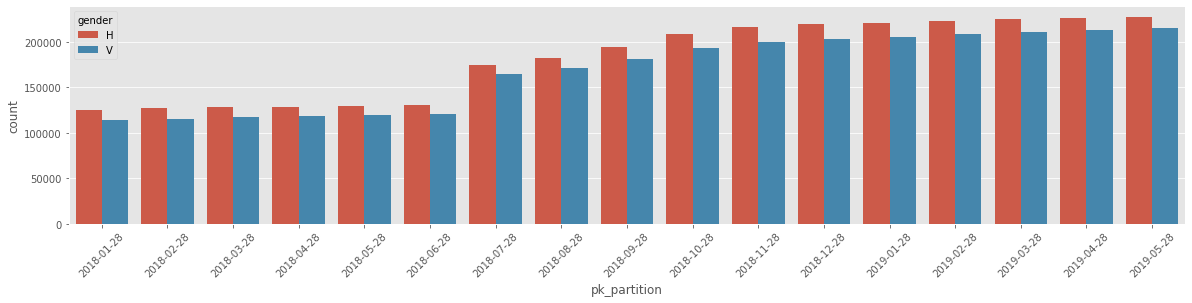

In [ ]:
plt.figure(figsize = [20,4])
plt.xticks(rotation=45)
sns.countplot(data = sociodemo, x = 'pk_partition', hue = 'gender' )

#### Deceased

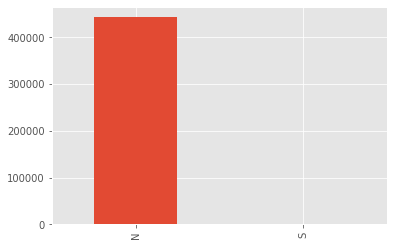

In [ ]:
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].deceased.value_counts().plot(kind='bar')

#### Salary

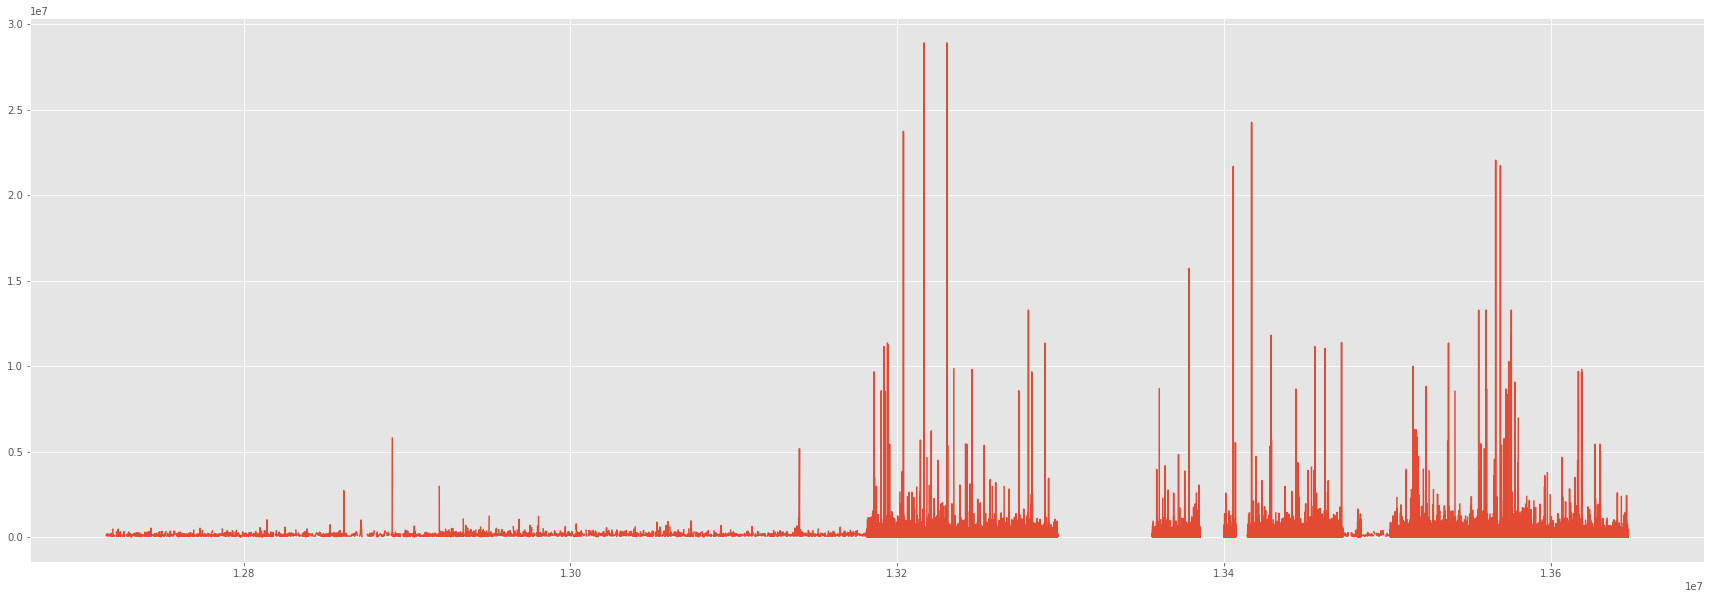

In [ ]:
fig= plt.subplots(figsize=(30,10))
sociodemo[sociodemo['pk_partition'] == '2019-05-28'].salary.plot()

## 2) Data Understanding - Commercial Activity

### Visualización, tamaño, tipos, estad.

In [ ]:
comm.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01-28,2018-01-12,KHL,1.00,02 - PARTICULARES
1,1050611,2018-01-28,2015-08-10,KHE,0.00,03 - UNIVERSITARIO
2,1050612,2018-01-28,2015-08-10,KHE,0.00,03 - UNIVERSITARIO
3,1050613,2018-01-28,2015-08-10,KHD,0.00,03 - UNIVERSITARIO
4,1050614,2018-01-28,2015-08-10,KHE,1.00,03 - UNIVERSITARIO


In [ ]:
comm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 318.5+ MB


In [ ]:
# pk_cid es identificador, debería ser un object
# pk_partition es una fecha
# entry date debería ser fecha
#active customer al ser booleano podria ser int

In [ ]:
comm.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,"5,962,924.00","1,234,929.80","162,302.04","15,891.00","1,112,532.00","1,231,097.00","1,352,339.00","1,553,689.00"
active_customer,"5,962,924.00",0.40,0.49,0.00,0.00,0.00,1.00,1.00


In [ ]:
comm.describe(include= 'object').T

,count,unique,top,freq
pk_partition,5962924,17,2019-05-28,442995
entry_date,5962924,1499,2017-07-28,57389
entry_channel,5829891,68,KHE,3113947
segment,5828980,3,03 - UNIVERSITARIO,3900166


In [ ]:
comm['segment'].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [ ]:
comm['active_customer'].value_counts()

0.00    3557573
1.00    2405351
Name: active_customer, dtype: int64

In [ ]:
comm['entry_channel'].value_counts()
#hay números y letras

KHE    3113947
KFC     890620
KHQ     590280
KAT     416084
KHK     230197
KHM     176591
KHN     108434
KFA      79020
KHD      75899
RED      60601
KHL      41736
KHF      20657
KHO       8247
KAZ       5635
KHC       5241
KBG       1662
KEH        728
KHP        691
007        613
013        397
KAG        335
KAS        305
KBZ        198
KAA        193
KAR        157
KAY        149
KAF        123
KAB         95
KFD         91
KCC         89
KAW         65
KAQ         52
KDH         51
KAE         48
KCH         48
KCB         47
KAD         45
KAM         43
KAH         40
KAK         34
KAJ         33
KDT         23
KFF         22
KBO         21
KEY         20
KGC         17
004         17
KFS         17
KCL         17
KBE         17
KBH         17
KFK         17
KGN         17
KCI         17
KGX         17
KDR         16
KFL         13
KBW         12
KBU         11
KAI         11
KCK         11
KBY         11
KES         11
KEJ          8
KHS          5
KDA          2
KFP       

### Valores Nulos

In [ ]:
comm.select_dtypes(include = ['number']).isnull().sum()

pk_cid             0
active_customer    0
dtype: int64

In [ ]:
comm.select_dtypes(include = ['object']).isnull().sum()

pk_partition          0
entry_date            0
entry_channel    133033
segment          133944
dtype: int64

In [ ]:
#muchos valores vacíos para entry channel y segment

In [ ]:
comm[comm['entry_channel'].isnull()].groupby(['pk_partition', 'segment']).count()

pk_cid  ...  active_customer
pk_partition segment                     ...                 
2018-01-28   02 - PARTICULARES        2  ...                2
             03 - UNIVERSITARIO       1  ...                1
2018-02-28   02 - PARTICULARES        2  ...                2
             03 - UNIVERSITARIO       1  ...                1
2018-03-28   02 - PARTICULARES        3  ...                3
             03 - UNIVERSITARIO       1  ...                1
2018-04-28   02 - PARTICULARES        3  ...                3
             03 - UNIVERSITARIO       1  ...                1
2018-05-28   02 - PARTICULARES        3  ...                3
             03 - UNIVERSITARIO       1  ...                1
2018-06-28   02 - PARTICULARES        7  ...                7
             03 - UNIVERSITARIO       1  ...                1
2018-07-28   02 - PARTICULARES       41  ...               41
             03 - UNIVERSITARIO       2  ...                2
2018-08-28   02 - PARTICULARES       30  ...               30
             03 - UNIVERSITARIO      13  ...               13
2018-09-28   02 - PARTICULARES       34  ...               34
             03 - UNIVERSITARIO      10  ...               10
2018-10-28   02 - PARTICULARES       50  ...               50
             03 - UNIVERSITARIO      45  ...               45
2018-11-28   01 - TOP                 1  ...                1
             02 - PARTICULARES       37  ...               37
             03 - UNIVERSITARIO      19  ...               19
2018-12-28   01 - TOP                 3  ...                3
             02 - PARTICULARES       63  ...               63
             03 - UNIVERSITARIO      15  ...               15
2019-01-28   01 - TOP                 3  ...                3
             02 - PARTICULARES       48  ...               48
             03 - UNIVERSITARIO      13  ...               13
2019-02-28   01 - TOP                 1  ...                1
             02 - PARTICULARES       30  ...               30
             03 - UNIVERSITARIO       4  ...                4
2019-03-28   02 - PARTICULARES       49  ...               49
             03 - UNIVERSITARIO       5  ...                5
2019-04-28   01 - TOP                 3  ...                3
             02 - PARTICULARES       33  ...               33
             03 - UNIVERSITARIO       2  ...                2
2019-05-28   01 - TOP                 1  ...                1
             02 - PARTICULARES       26  ...               26
             03 - UNIVERSITARIO       3  ...                3

[40 rows x 4 columns]

In [ ]:
comm[comm['segment'].isnull()]['entry_channel'].value_counts()

KAT    439
KFC    438
KHM    160
KHN    141
KFA     84
RED     73
KHK     66
KHL     15
013      9
KAG      9
KCC      9
KAA      9
KHO      8
KHE      8
KAZ      6
KAS      6
KAY      5
KBO      4
007      3
KAF      3
KAW      2
KHQ      2
KFL      2
KHC      2
KAJ      2
KAQ      1
KDS      1
KEY      1
KFD      1
KCH      1
KCI      1
KDR      1
KBZ      1
KDT      1
KAB      1
KDA      1
KBG      1
KAH      1
KCK      1
KAR      1
KFP      1
Name: entry_channel, dtype: int64

### EDA

#### Usuarios activos

In [ ]:
comm.groupby(['pk_partition','active_customer']).count()['pk_cid']

pk_partition  active_customer
2018-01-28    0.00               131282
              1.00               108211
2018-02-28    0.00               131436
              1.00               111085
2018-03-28    0.00               131452
              1.00               113806
2018-04-28    0.00               131145
              1.00               116318
2018-05-28    0.00               130860
              1.00               119066
2018-06-28    0.00               130544
              1.00               121560
2018-07-28    0.00               210052
              1.00               129287
2018-08-28    0.00               216572
              1.00               136350
2018-09-28    0.00               230536
              1.00               144787
2018-10-28    0.00               250338
              1.00               151962
2018-11-28    0.00               260066
              1.00               156321
2018-12-28    0.00               263246
              1.00               159235
2019-01-28

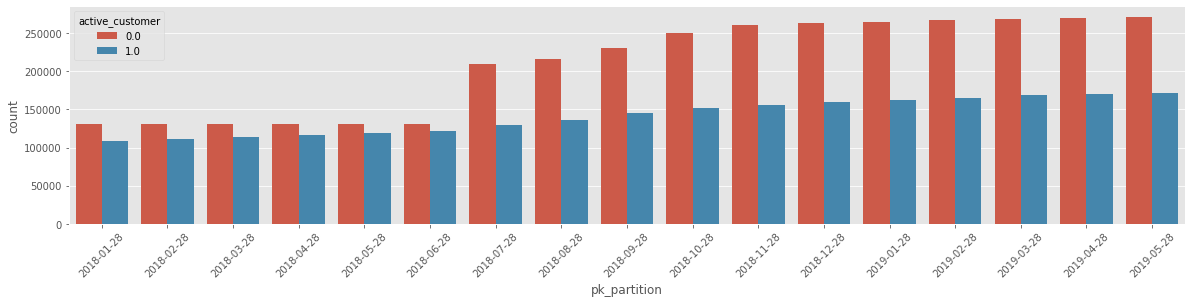

In [ ]:
plt.figure(figsize = [20,4])
plt.xticks(rotation=45)
sns.countplot(data = comm, x = 'pk_partition', hue = 'active_customer' )

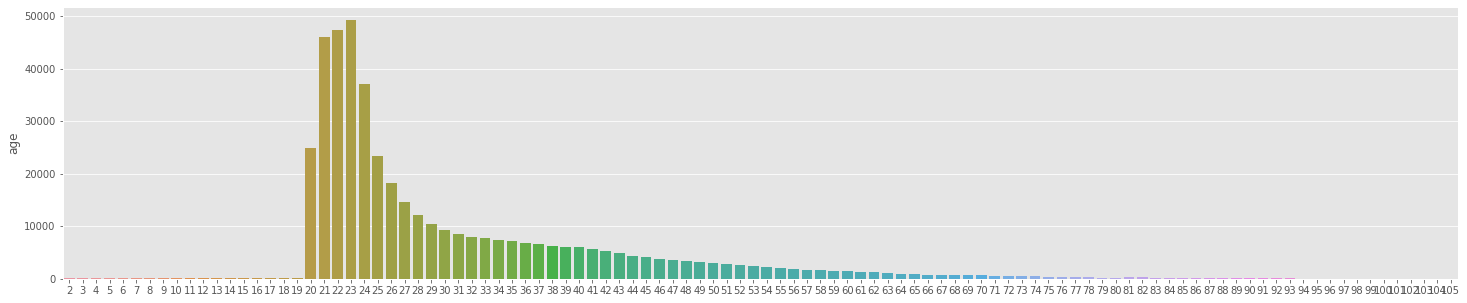

In [ ]:
dims = (25, 5)
fig= plt.subplots(figsize=dims)

sns.barplot(x=sociodemo[sociodemo['pk_partition'] == '2019-05-28'].age.value_counts().index, y=sociodemo[sociodemo['pk_partition'] == '2019-05-28'].age.value_counts())

#### Entry Channel

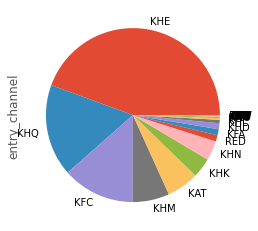

In [ ]:
comm[comm['pk_partition'] == '2019-05-28']['entry_channel'].value_counts().plot(kind='pie')

#### Segment

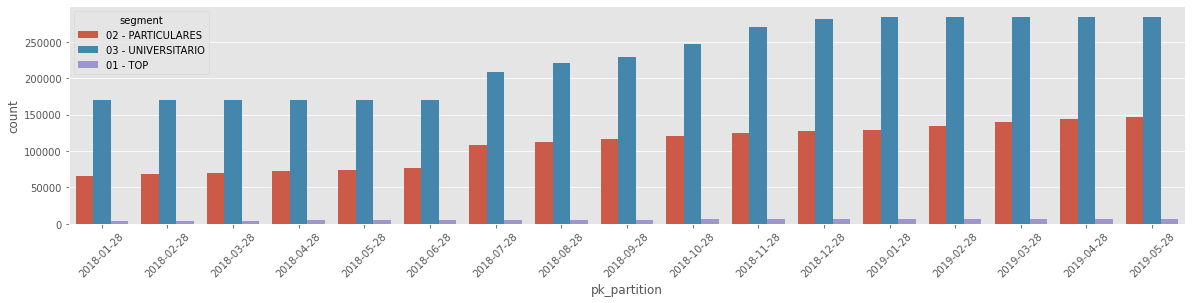

In [ ]:
plt.figure(figsize = [20,4])
plt.xticks(rotation=45)
sns.countplot(data = comm, x = 'pk_partition', hue = 'segment' )

#### Entry date

In [ ]:
#ver si los más antiguos son más inactivos o hay alguna tendencia

In [ ]:
comm['pk_partition'] = pd.to_datetime(comm['pk_partition'])

In [ ]:
comm['entry_date'] = pd.to_datetime(comm['entry_date'], errors='coerce')
#hay fechas como el 2015-02-29 que no existen

In [ ]:
entrydf = comm[comm['pk_partition'] == '2019-05-28'][['entry_date', 'pk_cid']].groupby(['entry_date']).count()
entrydf.head(26).sum()

pk_cid    1928
dtype: int64

In [ ]:
entrydfmonth = entrydf.resample('M').sum()
entrydfmonth.head()

,pk_cid
entry_date,
2015-01-31,1928
2015-02-28,1891
2015-03-31,2316
2015-04-30,2344
2015-05-31,2588


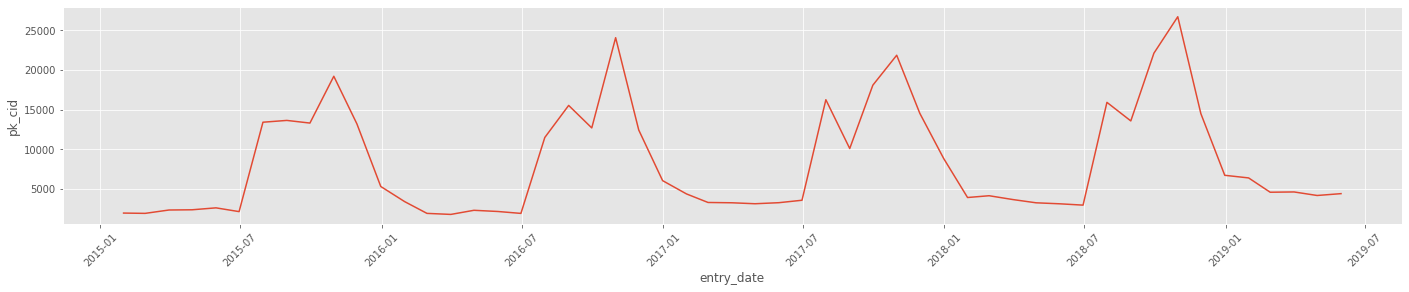

In [ ]:
plt.figure(figsize = [24,4])
plt.xticks(rotation=45)
sns.lineplot(x=entrydfmonth.index, y=entrydfmonth['pk_cid'])

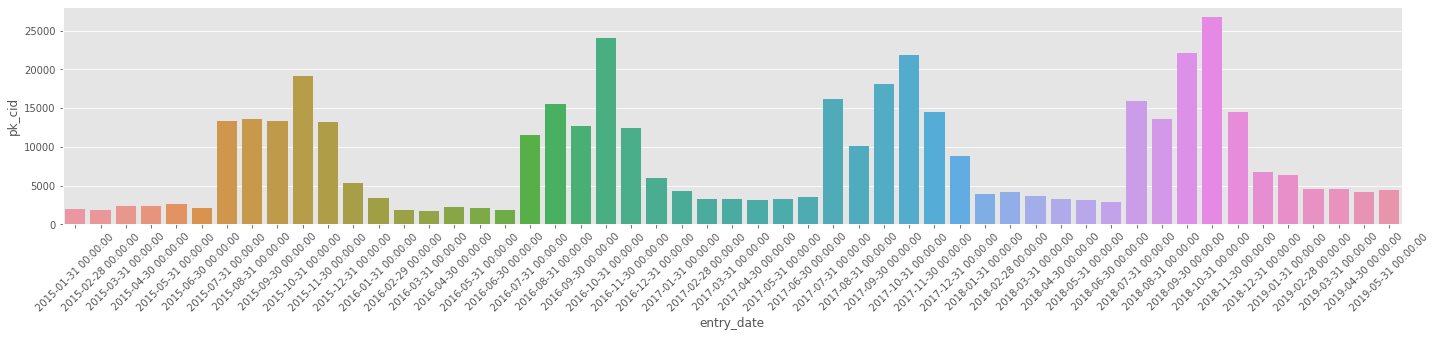

In [ ]:
plt.figure(figsize = [24,4])
plt.xticks(rotation=45)
sns.barplot(x=entrydfmonth.index, y=entrydfmonth['pk_cid'])

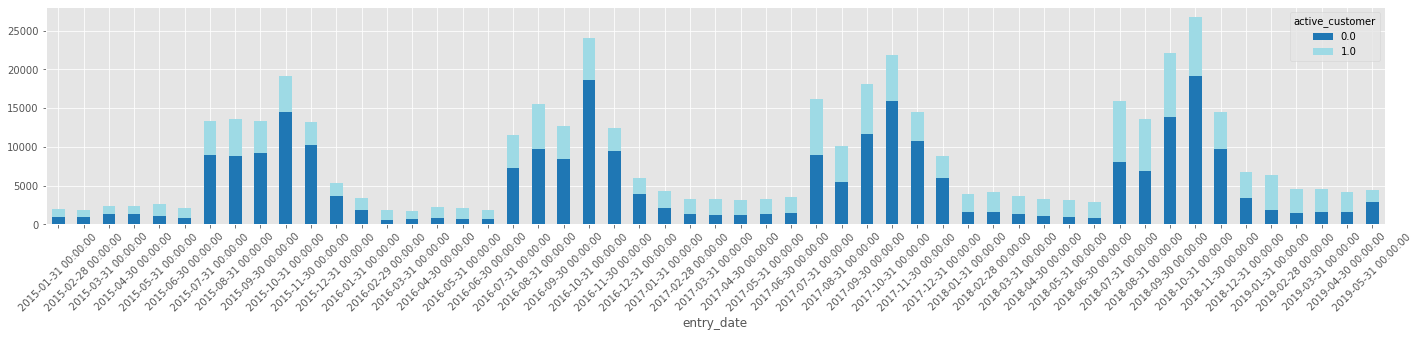

In [ ]:
df_pivot = pd.pivot_table(comm[comm['pk_partition'] == '2019-05-28'], index='entry_date', columns='active_customer', values='pk_cid', aggfunc='count')

(df_pivot.resample('M').sum()).plot.bar(stacked=True, figsize = [24,4], colormap='tab20')
plt.xticks(rotation=45)
plt.verbose = False

## MERGE DFs

In [ ]:
products.shape

(5962924, 17)

In [ ]:
products_sorted.shape

(5962924, 32)

In [ ]:
sociodemo.shape

(5962924, 8)

In [ ]:
comm.shape

(5962924, 6)

In [ ]:
# optimizamos el dataset convirtiendo a integers los numeros
numbers = products_sorted.select_dtypes(include = 'number').T.index.to_list()
products_sorted[numbers] = products_sorted[numbers].fillna(0)
products_sorted[numbers] = products_sorted[numbers].apply(lambda x: x.astype(int))
# optimizamos el dataset convirtiendo a integers los numeros
numbers = sociodemo.select_dtypes(include = 'number').T.index.to_list()
sociodemo[numbers] = sociodemo[numbers].fillna(0)
sociodemo[numbers] = sociodemo[numbers].apply(lambda x: x.astype(int))
# optimizamos el dataset convirtiendo a integers los numeros
numbers = comm.select_dtypes(include = 'number').T.index.to_list()
comm[numbers] = comm[numbers].fillna(0)
comm[numbers] = comm[numbers].apply(lambda x: x.astype(int))

### Sociodemo - Products_sorted

In [ ]:
set(sociodemo['pk_cid']) ^ set(products_sorted['pk_cid'])

set()

In [ ]:
set(sociodemo['pk_partition']) ^ set(products_sorted['pk_partition'])

{'2018-01-28',
 datetime.date(2018, 1, 28),
 '2018-02-28',
 datetime.date(2018, 2, 28),
 '2018-03-28',
 datetime.date(2018, 3, 28),
 datetime.date(2018, 4, 28),
 '2018-04-28',
 '2018-05-28',
 datetime.date(2018, 5, 28),
 '2018-06-28',
 datetime.date(2018, 6, 28),
 datetime.date(2018, 7, 28),
 '2018-07-28',
 '2018-08-28',
 datetime.date(2018, 8, 28),
 '2018-09-28',
 datetime.date(2018, 9, 28),
 datetime.date(2018, 10, 28),
 '2018-10-28',
 '2018-11-28',
 datetime.date(2018, 11, 28),
 '2018-12-28',
 datetime.date(2018, 12, 28),
 datetime.date(2019, 1, 28),
 '2019-01-28',
 datetime.date(2019, 2, 28),
 '2019-02-28',
 datetime.date(2019, 3, 28),
 '2019-03-28',
 '2019-04-28',
 datetime.date(2019, 4, 28),
 datetime.date(2019, 5, 28),
 '2019-05-28'}

In [ ]:
#no hace merge pq no tienen el mismo type, por eso el set muetra valores de diferencia

In [ ]:
sociodemo['pk_partition'] = (pd.to_datetime(sociodemo['pk_partition'])).dt.date
#cambiamos el type

In [ ]:
set(sociodemo['pk_partition']) ^ set(products_sorted['pk_partition'])

set()

In [ ]:
socio_prod = pd.merge(sociodemo, products_sorted,  how='inner', on=['pk_cid','pk_partition'])

In [ ]:
socio_prod[socio_prod['pk_cid'] == 1375586]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,dif_short_term_deposit,dif_loans,dif_mortgage,dif_funds,dif_securities,dif_long_term_deposit,dif_em_account_pp,dif_credit_card,dif_payroll,dif_pension_plan,dif_payroll_account,dif_emc_account,dif_debit_card,dif_em_account_p,dif_em_acount
0,1375586,2018-01-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
346322,1375586,2018-02-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
592407,1375586,2018-03-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
831104,1375586,2018-04-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1108457,1375586,2018-05-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1357280,1375586,2018-06-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1791360,1375586,2018-07-28,ES,29,H,35,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1988936,1375586,2018-08-28,ES,29,H,36,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0
2487565,1375586,2018-09-28,ES,29,H,36,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2753984,1375586,2018-10-28,ES,29,H,36,N,87218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#deberíamos tener en cuenta que si en la primera partición es un 0, lo tamaríamos como una alta??? Imputación de nulos para tener en cuenta!

### S-P con comm

In [ ]:
socio_prod.shape

(5962924, 38)

In [ ]:
comm['pk_partition'] = (pd.to_datetime(comm['pk_partition'])).dt.date
#cambiamos el type

In [ ]:
set(socio_prod['pk_partition']) ^ set(comm['pk_partition'])

set()

In [ ]:
set(socio_prod['pk_cid']) ^ set(comm['pk_cid'])

set()

In [ ]:
df = pd.merge(socio_prod, comm,  how='left', on=['pk_cid','pk_partition'])

In [ ]:
# lo hemos trabajado en local porque la RAM no era suficiente: df.to_pickle(PATH+'df_pickle.pkl')